# Deep Convolutional Neural Networks

Klasycznie w sieciach konwolucyjnych używane były warstwy konwolucyjne z aktywacją ReLU naprzemiennie z poolingiem, a na końcu architektury umieszczany był klasyfikator składający się z warstw w pełni połączonych. Obecne architektury głębokie odchodzą od tego schematu na rzecz różnego rodzaju bloków operacji. Część sieci próbuje rozbudowywać architektury wszerz, na przykład przez wprowadzenie bloków incepcyjnych, które przetwarzają dane równolegle w zróżnicowanych gałęziach (patrz rys. poniżej). Inne podejścia z kolei wprowadzają do architektury krawędzie omijające niektóre warstwy (patrz zadanie 2).

![inception](utils/inception.png)

### Wczytywanie Danych

Na tych zajęciach będziemy pracować ze zbiorem danych **CIFAR-10**, który zawiera 10 klas po 6000 kolorowych obrazków o wymiarach 32x32. Przykładowe zdjęcia są generowane przez poniższy blok kodu. Po wczytaniu danych **znormalizujemy każdy z kanałów obrazków** (teraz są 3 kanały RGB, wcześniej w przypadku MNIST-a był tylko jeden kanał odcieni szarości). Dodatkowo zbiór treningowy będzie rozszerzony (ang. **data augmentation**) o losowe transformacje. Jest to często używana technika przy uczeniu sieci konwolucyjnych, która daje efekt regularyzacji.

**Zadanie 1**: Dodać normalizację danych i następujące rozszerzenia zbioru treningowego:
- losowe odbicie lustrzane,
- losowy obrót o 10 stopni.

Uwaga: należy pamiętać o zamianie obrazów PIL na tensory.

Files already downloaded and verified


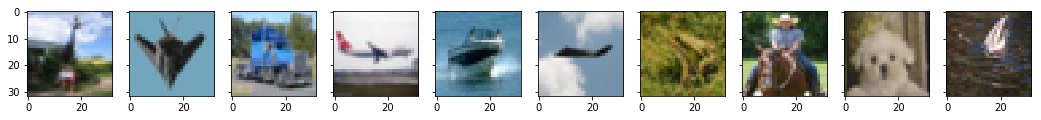

In [0]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

torch.manual_seed(7)

# średnia i odchylenie standardowe danych treningowych policzone dla 3 kanałów
mean = (0.49139968,  0.48215841,  0.44653091)
std = (0.24703223,  0.24348513,  0.26158784)

'''
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mi], std=[st], inplace=True),
    transforms.RandomCrop(32, padding=4),
    transforms.Lambda(lambda x: x.view(784))
])
'''

# wstępne przetwarzanie danych - normalizacja
transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=mean, std=std, inplace=True),
])

# preprocessing + augmentacja
transforms_with_augmentation = tv.transforms.Compose([
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(10),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=mean, std=std, inplace=True),
])



# dane treningowe są dodatkowo rozszerzone o losowe transformacje
# dane testowe nie podlegają rozszerzeniu, aby zachować powtarzalność wyników
train_dataset = tv.datasets.CIFAR10('.', train=True, transform=transforms_with_augmentation, download=True)
test_dataset = tv.datasets.CIFAR10('.', train=False, transform=transforms)

# wyświetlenie 10 losowych zdjęć ze zbioru danych
f, ax = plt.subplots(1, 10, sharex='col', sharey='row', figsize=(18, 16))
for a in ax:
    a.imshow(train_dataset.data[np.random.randint(len(train_dataset))])
plt.show()

In [0]:
import matplotlib.pyplot as plt


def show_results(orientation='horizontal', accuracy_bottom=None, loss_top=None, **histories):
    if orientation == 'horizontal':
        f, ax = plt.subplots(1, 2, figsize=(16, 5))
    else:
        f, ax = plt.subplots(2, 1, figsize=(16, 16))
    for i, (name, h) in enumerate(histories.items()):
        if len(histories) == 1:
            ax[0].set_title("Best test accuracy: {:.2f}% (train: {:.2f}%)".format(
                max(h['test_accuracy']) * 100,
                max(h['train_accuracy']) * 100
            ))
        else:
            ax[0].set_title("Accuracy")
        ax[0].plot(h['train_accuracy'], color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[0].plot(h['test_accuracy'], color='C%s' % i, label='%s test' % name)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('accuracy')
        if accuracy_bottom:
            ax[0].set_ylim(bottom=accuracy_bottom)
        ax[0].legend()

        if len(histories) == 1:
            ax[1].set_title("Minimal train loss: {:.4f} (test: {:.4f})".format(
                min(h['train_loss']),
                min(h['test_loss'])
            ))
        else:
            ax[1].set_title("Loss")
        ax[1].plot(h['train_loss'], color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[1].plot(h['test_loss'], color='C%s' % i, label='%s test' % name)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('loss')
        if loss_top:
            ax[1].set_ylim(top=loss_top)
        ax[1].legend()

    plt.show()

In [0]:
import torch
from tqdm import trange


class ModelTrainer:
    def __init__(self, train_dataset, test_dataset, batch_size=128):
        self.batch_size = batch_size
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def train(self, model, optimizer, loss_fn=torch.nn.functional.cross_entropy, n_epochs=100):
        self.logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
        model = model.to(self.device)
        correct, numel = 0, 0
        for e in trange(1, n_epochs + 1):
            model.train()
            for x, y in self.train_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                optimizer.zero_grad()
                output = model(x)
                y_pred = torch.argmax(output, dim=1)
                correct += torch.sum(y_pred == y).item()
                numel += self.batch_size
                loss = loss_fn(output, y)
                loss.backward()
                optimizer.step()

            self.logs['train_loss'].append(loss.item())
            self.logs['train_accuracy'].append(correct / numel)
            correct, numel = 0, 0

            model.eval()
            with torch.no_grad():
                for x_test, y_test in self.test_loader:
                    x_test = x_test.to(self.device)
                    y_test = y_test.to(self.device)
                    output = model(x_test)
                    y_pred = torch.argmax(output, dim=1)
                    correct += torch.sum(y_pred == y_test).item()
                    numel += self.batch_size
                loss = loss_fn(output, y_test)

            self.logs['test_loss'].append(loss.item())
            self.logs['test_accuracy'].append(correct / numel)
            correct, numel = 0, 0

        return self.logs


---

### Opis Architektury

Poniższy blok kodu zawiera moduł `ConvNet`, który opisuje makroarchitekturę sieci konwolucyjnej. Wewnątrz niej znajduje się wymienialny blok (mikroarchitektura), który w wersji `BaseBlock` zawiera 2 warstwy konwolucyjne z batch normalization i ReLU. Dalsze ćwiczenia polegać będą na zamianie mikroarchitektury. Żeby wytrenować sieć, należy odpowiednio dobrać liczbę epok. Należy jednak mieć na uwadze, że architektury te będą uczyć się dłużej niż sieci z poprzednich zajęć.


100%|██████████| 10/10 [50:27<00:00, 302.42s/it]


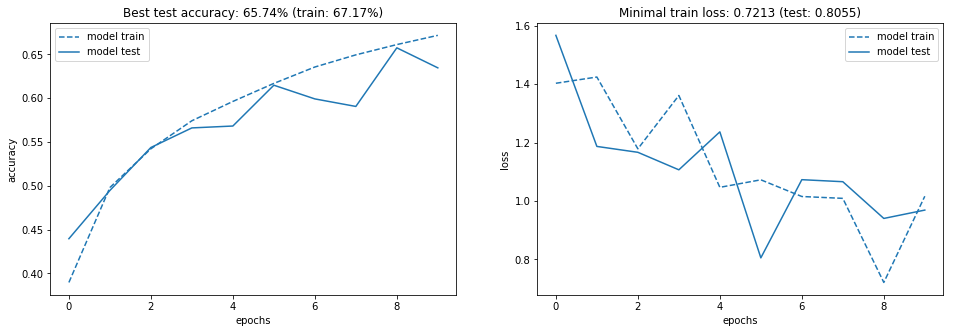

Number of parameters: 53578


In [0]:
class BaseBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super(BaseBlock, self).__init__()
        if not hidden_channels:
            hidden_channels = out_channels
            
        # konwolucja zawiera padding=1, aby nie zmniejszać rozmiaru obrazu
        self.conv1 = torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        # istnieje wersja batch normalization dla obrazów - statystyki dla filtrów
        self.batch_norm1 = torch.nn.BatchNorm2d(hidden_channels)
        # nieliniowość ReLU
        self.relu1 = torch.nn.ReLU()
        
        # drugi raz te same warstwy
        self.conv2 = torch.nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU()
    
    def forward(self, x):
        out = self.relu1(self.batch_norm1(self.conv1(x)))
        out = self.relu2(self.batch_norm2(self.conv2(out)))
        return out

    
class ConvNet(torch.nn.Module):
    
    def __init__(self, block):
        super(ConvNet, self).__init__()
        
        # wstępna warstwa konwolucyjna + ReLU
        self.conv = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = torch.nn.ReLU()
        
        # (mikroarchitektura + max pooling) x 2
        self.block1 = block(16, 32)
        self.pool1 = torch.nn.MaxPool2d(2)
        self.block2 = block(32, 32)
        self.pool2 = torch.nn.MaxPool2d(2)
        
        # warstwa w pełni połączona po "rozprostowaniu" obrazu do postaci wektora
        self.dense = torch.nn.Linear(8 * 8 * 32, 10)
    
    def forward(self, x):
        out = self.relu(self.conv(x))
        out = self.block1(out)
        out = self.pool1(out)
        out = self.block2(out)
        out = self.pool2(out)
        out = out.view(out.size(0), -1)
        return self.dense(out)


def run_model(model, n_epochs):
    trainer = ModelTrainer(train_dataset, test_dataset, batch_size=256)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    history = trainer.train(model, optimizer, n_epochs=n_epochs)
    show_results(model=history)
    n_parameters = sum([np.prod(p.size()) for p in model.parameters()])
    print("Number of parameters:", n_parameters)


base_model = ConvNet(BaseBlock)
run_model(base_model, n_epochs=10)

---

### Wizualizacja Mikroarchitektury

Aby zweryfikować poprawność grafu bez uczenia całej sieci, można pobrać bibliotekę do wizualizacji sieci. Aby to zrobić, należy odkomentować i uruchomić poniższy blok. Funkcja `vizualize_block` rysuje skierowany graf, gdzie parametry sieci oznaczone są na niebiesko, a kolorem szarym oznaczone są wykonywane kolejno działania. Graf taki może okazać się szczególnie przydatny przy tworzeniu modułów z kilkoma równoległymi gałęziami.

In [14]:
import sys
!conda install --yes --prefix {sys.prefix} graphviz
!conda install --yes --prefix {sys.prefix} python-graphviz
!{sys.executable} -m pip install torchviz

/bin/bash: conda: command not found
/bin/bash: conda: command not found
    100% |████████████████████████████████| 51kB 3.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


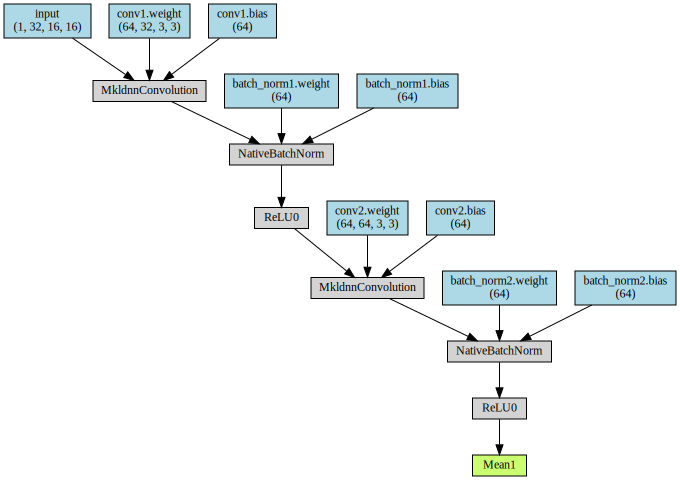

In [15]:
from torchviz import make_dot

def vizualize_block(block, input_shape=(1, 32, 16, 16), output_channels=64):
    model = block(input_shape[1], output_channels)
    x = torch.randn(input_shape).requires_grad_(True)
    y = model(x)
    g = make_dot(y.mean(), params=dict(list(model.named_parameters()) + [('input', x)]))
    g.body = [v.replace('Backward', '').replace('Threshold', 'ReLU') for v in g.body]
    return g

vizualize_block(BaseBlock)

### I. ResNet

Jedną z najistotniejszych architektur konwolucyjnych jest ResNet, który wprowadza połączenia rezydualne. Rysunek poniżej przedstawia blok rezydualny z połączeniem skrótowym (*shortcut connection*). Połączenia takie można traktować jako równoległe gałęzie sieci wykonujące operację identyczności. Pomaga to walczyć z degradacją dokładności sieci, która objawia się przez pogorszenie wyniku sieci wraz ze zwiększaniem jej głębokości.

![residual](utils/residual.png)

**Zadanie 2**: Zaimplementować blok rezydualny architektury ResNet.

1. Moduł ma zawierać **2 konwolucje 3x3 o `hidden_channels` filtrach** z **batch normalization** i nieliniowością **ReLU** pomiędzy nimi.
2. Dodane powinno zostać **połączenie skrótowe**, które dodaje wejście modułu do wyniku drugiej konwolucji.
3. Do wyniku dodawania powinna być dodana **warstwa batch norm i druga operacja ReLU**.

Uwaga: aby operacja dodawania była wykonywalna w przypadku `in_channels` < `out_channels`, należy dodać padding zerami do wejścia lub użyć konwolucji 1x1 o `out_channels` filtrach. Oba te podejścia są rozważane przez autorów ResNeta.



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [05:45<51:45, 345.03s/it]

 20%|██        | 2/10 [11:29<45:58, 344.81s/it]

 30%|███       | 3/10 [17:13<40:12, 344.57s/it]

 40%|████      | 4/10 [22:57<34:27, 344.50s/it]

 50%|█████     | 5/10 [28:41<28:41, 344.24s/it]

 60%|██████    | 6/10 [34:23<22:54, 343.62s/it]

 70%|███████   | 7/10 [40:06<17:10, 343.36s/it]

 80%|████████  | 8/10 [45:50<11:27, 343.54s/it]

 90%|█████████ | 9/10 [51:34<05:43, 343.86s/it]

100%|██████████| 10/10 [57:17<00:00, 343.62s/it]



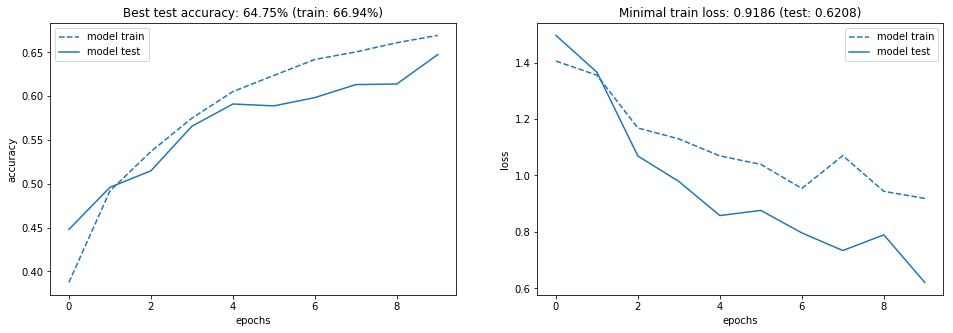

Number of parameters: 55178


In [17]:
class ResNetBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super(ResNetBlock, self).__init__()
        if not hidden_channels:
            hidden_channels = out_channels
        
        self.conv1 = torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.batch_norm1 = torch.nn.BatchNorm2d(hidden_channels)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = torch.nn.Sequential()
        
        self.conv1on1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        self.batch_norm2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU()
    
    def forward(self, x):
        out = self.relu1(self.batch_norm1(self.conv1(x)))
        out = self.conv2(out)
        out += self.shortcut(self.conv1on1(x))
        return self.relu2(self.batch_norm2(out))

resnet_model = ConvNet(ResNetBlock)
run_model(resnet_model, n_epochs=10)

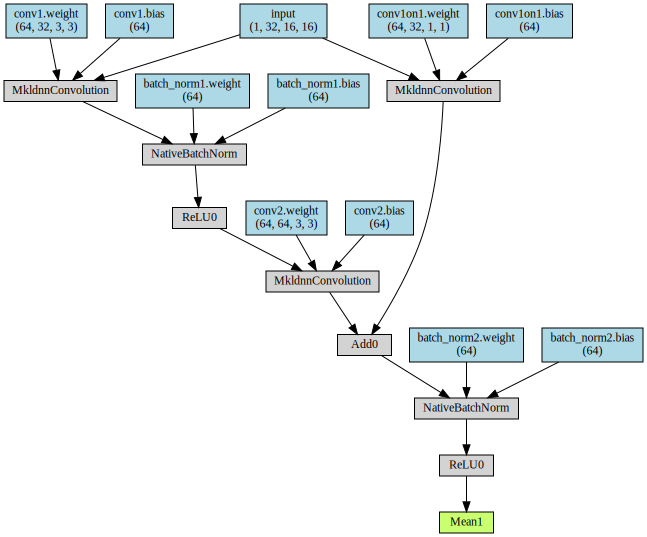

In [16]:
vizualize_block(ResNetBlock)

### II. SqueezeNet

Architekturę SqueezeNet można uznać za początek rozwoju mobilnych architektur konwolucyjnych. Charakteryzują się one zredukowaną liczbą parametrów i potrzebnych obliczeń przy zachowaniu wysokiej dokładności predykcji. Blok zwany Fire Module ma zastępować konwolucję 3x3 poprzez zredukowanie wymiaru wejścia (squeeze) i wykonywaniu kosztownej konwolucji 3x3 na zredukowanej przestrzeni (expand).

![squeeze](utils/squeeze.png)

**Zadanie 3**: Zaimplementować Fire Module z architektury SqueezeNet:

1. Pierwsza warstwa bloku (squeeze) zawiera **konwolucję 1x1 o `hidden_channels` filtrach, batch normalization i ReLU**.
2. Wyjście z pierwszej warstwy jest wejściem do dwóch **warstw konwolucyjnych 1x1 i 3x3** (expand). Całkowita liczba ich filtrów to w sumie `out_channels`.
3. Wyjścia są **łączone wzdłuż filtrów**, stosowane jest **batch normalization i ReLU**.




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [02:53<26:04, 173.80s/it]


 20%|██        | 2/10 [05:48<23:11, 174.00s/it]


 30%|███       | 3/10 [08:44<20:22, 174.63s/it]


 40%|████      | 4/10 [11:40<17:29, 174.96s/it]


 50%|█████     | 5/10 [14:34<14:33, 174.78s/it]


 60%|██████    | 6/10 [17:29<11:39, 174.96s/it]


 70%|███████   | 7/10 [20:24<08:44, 174.92s/it]


 80%|████████  | 8/10 [23:19<05:49, 174.97s/it]


 90%|█████████ | 9/10 [26:13<02:54, 174.56s/it]


100%|██████████| 10/10 [29:08<00:00, 174.80s/it]




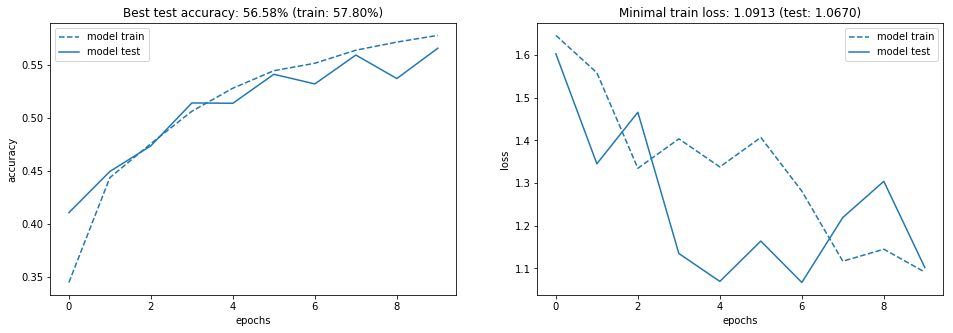

Number of parameters: 24122


In [29]:
class SqueezeNetBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels=8):
        super(SqueezeNetBlock, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=1),
            torch.nn.BatchNorm2d(hidden_channels),
            torch.nn.ReLU()
        )
        self.ex_1 = torch.nn.Conv2d(hidden_channels, out_channels//2, kernel_size=3, padding=1)
        self.ex_2 = torch.nn.Conv2d(hidden_channels, out_channels//2, kernel_size=1)
        self.final_layer = torch.nn.Sequential(
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
        )
    
    def forward(self, x):
        out = self.layer1(x)
        cat_expand = torch.cat([
            self.ex_1(out),
            self.ex_2(out)
        ], 1)
        return self.final_layer(cat_expand)        

squeezenet_model = ConvNet(SqueezeNetBlock)
run_model(squeezenet_model, n_epochs=10)

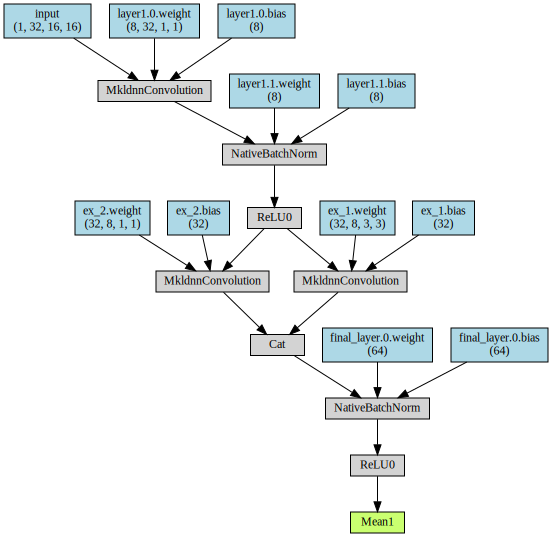

In [30]:
vizualize_block(SqueezeNetBlock)